In [1]:
import pandas as pd, numpy as np
import os
import glob
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from statsmodels.tsa.stattools import adfuller
from pylab import rcParams
import statsmodels.api as sm
rcParams['figure.figsize'] = 15, 8
from sklearn.metrics import mean_squared_error
import math, itertools
import warnings
warnings.filterwarnings('ignore')
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

### Dataset import and time-series generation 
 - importing dataset containing timestamp of each checkin for the businesses

In [2]:
check_df = pd.concat([pd.read_parquet(f) for f in glob.glob(os.getcwd()+'/filtered_data/checkin/*.parquet')], ignore_index=True)

In [3]:
print("Shape:",check_df.shape)
print("No. of business:",len(check_df.business_id.unique()))
check_df.head()

Shape: (40632, 2)
No. of business: 40632


business_id                                               date
0  -6c_bJblLXUwoWfmYLtH_w  2017-09-11 21:09:29, 2017-09-13 19:44:34, 2018...
1  -Gh9a15ijNii-8rnp4x3xA                                2015-01-28 16:13:00
2  -TGwtTiieh_JLml5_VRMQA  2010-08-21 19:05:19, 2011-04-08 13:34:47, 2011...
3  -VAsjhmAbKF3Pb_-8rh3xg  2013-09-09 21:24:17, 2013-09-11 16:10:00, 2013...
4  -r8SvItXXG6_T3mP5GXRAw  2011-03-21 21:08:34, 2011-09-09 19:08:55, 2011...

- splitting the string and exploding the list to get individual timestamps as a record 
- type casting timestamp string to datetime  

In [4]:
check_df['date'] = check_df.date.apply(lambda x: x.split(','))
check_df = check_df.explode('date').reset_index().drop('index',axis=1)
check_df['date'] = pd.to_datetime(check_df.date)
check_df.head()

business_id                date
0  -6c_bJblLXUwoWfmYLtH_w 2017-09-11 21:09:29
1  -6c_bJblLXUwoWfmYLtH_w 2017-09-13 19:44:34
2  -6c_bJblLXUwoWfmYLtH_w 2018-02-20 22:01:45
3  -6c_bJblLXUwoWfmYLtH_w 2018-03-14 21:39:04
4  -6c_bJblLXUwoWfmYLtH_w 2018-03-23 23:14:52

In [5]:
check_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2083371 entries, 0 to 2083370
Data columns (total 2 columns):
 #   Column       Dtype         
---  ------       -----         
 0   business_id  object        
 1   date         datetime64[ns]
dtypes: datetime64[ns](1), object(1)
memory usage: 31.8+ MB


- importing dataset containing location information of businesses

In [6]:
bus_df = pd.concat([pd.read_parquet(f) for f in glob.glob(os.getcwd()+'/filtered_data/business/*.parquet')], ignore_index=True)

In [7]:
print("Shape:",bus_df.shape)
print("No. of business:",len(bus_df.business_id.unique()))
print("No. of cities:",len(bus_df.city.unique()))
print("Cities:",list(bus_df.city.unique()))
print("Provinces:",list(bus_df.state.unique()))
bus_df.head()

Shape: (47110, 14)
No. of business: 47110
No. of cities: 10
Cities: ['Toronto', 'Calgary', 'Richmond Hill', 'Montréal', 'Scarborough', 'Markham', 'Mississauga', 'Brampton', 'Vaughan', 'North York']
Provinces: ['ON', 'AB', 'QC', 'BC', 'YT', 'MB', 'AL', 'OH']


city                       address  \
0        Toronto  700 Kipling Avenue Etobicoke   
1        Calgary                                 
2        Toronto              306 Yonge Street   
3        Toronto             415 Horner Avenue   
4  Richmond Hill            13071 Yonge Street   

                                          attributes             business_id  \
0  {'AcceptsInsurance': None, 'AgesAllowed': None...  EosRKXIGeSWFYWwpkbhNnA   
1                                               None  MbZMmwo-eL0Jnm_Yb9KJrA   
2  {'AcceptsInsurance': None, 'AgesAllowed': None...  1wWneWD_E1pBIyVpdHMaQg   
3  {'AcceptsInsurance': None, 'AgesAllowed': None...  007Dg4ESDVacWcC4Vq704Q   
4  {'AcceptsInsurance': None, 'AgesAllowed': None...  9sRGfSVEfLhN_km60YruTA   

                                          categories  \
0  Martial Arts, Gyms, Fitness & Instruction, Act...   
1            Contractors, Landscaping, Home Services   
2                     Shopping, Shoe Stores, Fashion   
3  Shopping, Food, Organic Stores, Specialty Food...   
4  Persian/Iranian, Turkish, Middle Eastern, Rest...   

                                               hours  is_open   latitude  \
0  {'Friday': '5:30-23:0', 'Monday': '5:30-23:0',...        1  43.624539   
1  {'Friday': '7:0-17:0', 'Monday': '7:0-17:0', '...        1  50.945960   
2  {'Friday': '10:0-21:0', 'Monday': '10:0-21:0',...        1  43.656542   
3  {'Friday': '9:0-16:0', 'Monday': '9:0-16:0', '...        0  43.603232   
4  {'Friday': '12:0-0:0', 'Monday': None, 'Saturd...        1  43.947011   

    longitude                            name postal_code  review_count  \
0  -79.529108                  Xtreme Couture     M8Z 5G3            16   
1 -114.037207  Chinook Landscaping and Design     T2J 2P2             3   
2  -79.381308                Air Jordan Store     M5B 1R4             9   
3  -79.538424             Front Door Organics     M8W 4W3             8   
4  -79.454862              Apadana Restaurant     L4E 1A5             3   

   stars state  
0    3.0    ON  
1    5.0    AB  
2    4.0    ON  
3    4.0    ON  
4    3.0    ON

- converting Montréal (accented) -> Montreal (unaccented)

In [8]:
import unidecode

bus_df['city'] = bus_df.city.apply(lambda x: unidecode.unidecode(x))
bus_df['state'] = np.select(
    [
        bus_df['city'].isin(['Toronto', 'Richmond Hill', 'Scarborough', 'Markham', 'Mississauga', 'Brampton', 'Vaughan', 'North York']),
        bus_df['city'].isin(['Calgary']),
        bus_df['city'].isin(['Montreal']),
    ],
    [
        'ON',
        'AB',
        'QC'
    ]
)

In [9]:
df = bus_df[['business_id','city']].merge(check_df,on=['business_id'],how='inner')
df['city'] = df.city.astype('category')
df.dtypes

business_id            object
city                 category
date           datetime64[ns]
dtype: object

- extracting only date information from datetime object for aggregation on daily level

In [10]:
df['date'] = df.date.dt.date
df.head()

business_id     city        date
0  EosRKXIGeSWFYWwpkbhNnA  Toronto  2012-06-12
1  EosRKXIGeSWFYWwpkbhNnA  Toronto  2013-02-11
2  EosRKXIGeSWFYWwpkbhNnA  Toronto  2013-02-22
3  EosRKXIGeSWFYWwpkbhNnA  Toronto  2013-03-05
4  EosRKXIGeSWFYWwpkbhNnA  Toronto  2013-03-06

In [11]:
pivot_df = df.pivot_table(index='date',values='business_id',columns='city',aggfunc='count', fill_value=0)
pivot_df

city        Brampton  Calgary  Markham  Mississauga  Montreal  North York  \
date                                                                        
2010-01-16         1        8        0            0         1           0   
2010-01-17         0       10        0            0         3           1   
2010-01-18         0        4        4            0         0           0   
2010-01-19         0        2        0            0         0           1   
2010-01-20         0        8        0            3         3           1   
...              ...      ...      ...          ...       ...         ...   
2019-12-09         2       13       26           36        22          10   
2019-12-10         1       13       25           28        32           9   
2019-12-11         4       10       15           30        34           5   
2019-12-12         3        7       40           40        47           7   
2019-12-13         0        7       11           15        29           4   

city        Richmond Hill  Scarborough  Toronto  Vaughan  
date                                                      
2010-01-16              0            2       27        0  
2010-01-17              0            1       29        0  
2010-01-18              0            2       21        0  
2010-01-19              0            0       25        0  
2010-01-20              0            0       37        0  
...                   ...          ...      ...      ...  
2019-12-09              6           15      115        6  
2019-12-10             13            9      204        5  
2019-12-11              9            3      180        4  
2019-12-12             10           16      147        3  
2019-12-13              6            5      100        2  

[3619 rows x 10 columns]

- monthly aggregate of checkins for all businesses in cities 

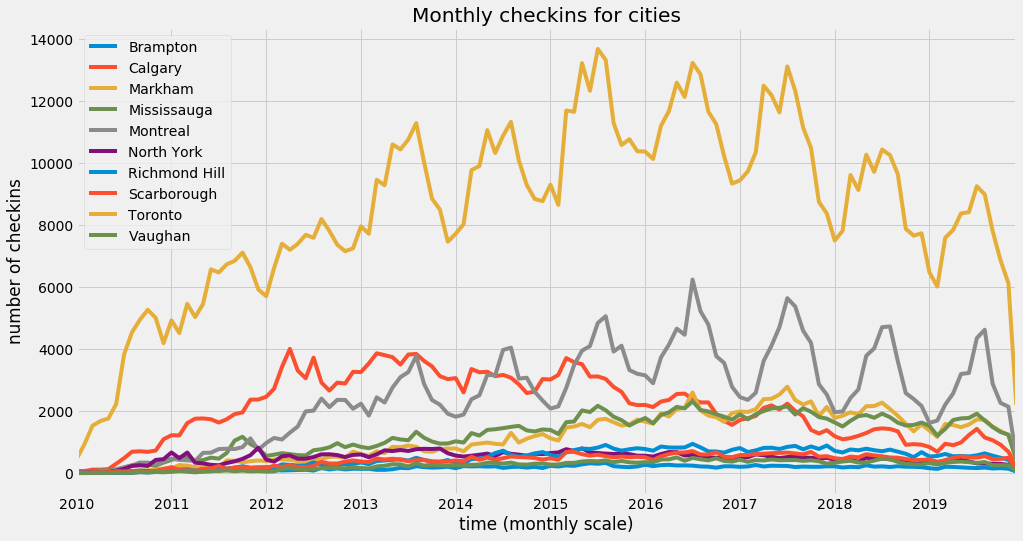

In [12]:
fig,ax=plt.subplots(figsize=(15,8))

pivot_df.index = pd.DatetimeIndex(pivot_df.index)
cities = list(pivot_df.columns)
for i in range(10):
    pivot_df.loc[:,cities[i]].resample('M').sum().plot(ax=ax)
ax.set(title='Monthly checkins for cities',xlabel='time (monthly scale)', \
       ylabel='number of checkins')
plt.legend()
plt.show()

- choosing 'Toronto' for further time series analysis and estimating parameters for different forecasting techniques
- aggregating data on two levels - 'daily', 'monthly'

In [13]:
daily_tor = pivot_df['Toronto'].resample('D').sum().reset_index().rename(columns={'date':'ds','Toronto':'y'}).set_index('ds')

monthly_tor = pivot_df['Toronto'].resample('M').sum().reset_index().rename(columns={'date':'ds','Toronto':'y'}).set_index('ds')


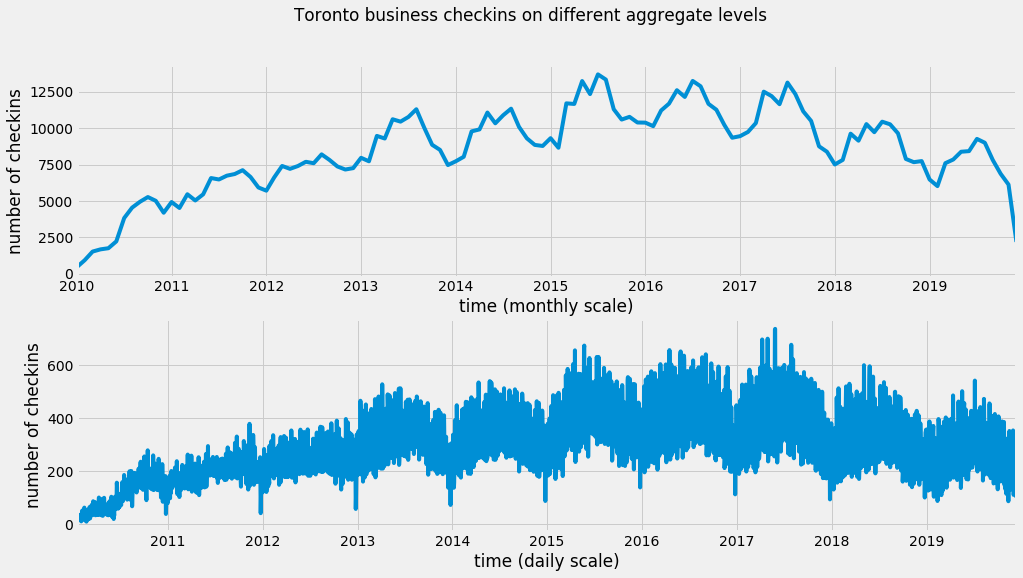

In [14]:
fig,ax = plt.subplots(2,1,figsize=(15,8))
monthly_tor.plot(ax=ax[0],legend=False)
daily_tor.plot(ax=ax[1],legend=False)
ax[0].set(xlabel='time (monthly scale)',ylabel='number of checkins')
ax[1].set(xlabel='time (daily scale)',ylabel='number of checkins')
fig.suptitle('Toronto business checkins on different aggregate levels')
plt.show()

### Stationarity test
- testing time series stationarity using Augmented Dickey-Fuller test

In [33]:
def test_stationarity(ts_df):
    dftest = adfuller(ts_df.dropna())
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print('\tTest statistic: ', dfoutput['Test Statistic'], 'p-value: ', dfoutput['p-value'])
    if dfoutput['Test Statistic'] <= dfoutput['Critical Value (1%)']:
        print ("\tNull hypothesis can be rejected with 99% confidence - TS is Stationary")
    elif dfoutput['Test Statistic'] <= dfoutput['Critical Value (5%)']:
        print ("\tNull hypothesis can be rejected with 95% confidence - TS is Stationary")
    elif dfoutput['Test Statistic'] <= dfoutput['Critical Value (10%)']:
        print ("\tNull hypothesis can be rejected with 80% confidence - TS is Stationary")
    else:
        print ("\tNull hypothesis is accepted - TS is Non-Stationary")

In [34]:
print('Monthly TS:')
test_stationarity(monthly_tor)
print('Monthly TS (First difference):')
test_stationarity(monthly_tor.diff())
print('Monthly TS (Second Difference):')
test_stationarity(monthly_tor.diff().dropna().diff())

Monthly TS:
	Test statistic:  -0.5004552230579933 p-value:  0.8919276322301207
	Null hypothesis is accepted - TS is Non-Stationary
Monthly TS (First difference):
	Test statistic:  -1.133732505881232 p-value:  0.7014340745922356
	Null hypothesis is accepted - TS is Non-Stationary
Monthly TS (Second Difference):
	Test statistic:  -6.92113763125659 p-value:  1.145687748778882e-09
	Null hypothesis can be rejected with 99% confidence - TS is Stationary


In [35]:
print('Daily TS:')
test_stationarity(daily_tor)
print('Daily TS (First Difference):')
test_stationarity(daily_tor.diff())
print('Daily TS (Second Difference):')
test_stationarity(daily_tor.diff().dropna().diff())

Daily TS:
	Test statistic:  -2.6579576492715438 p-value:  0.08160022397522099
	Null hypothesis can be rejected with 80% confidence - TS is Stationary
Daily TS (First Difference):
	Test statistic:  -16.53449454592756 p-value:  2.009640002959654e-29
	Null hypothesis can be rejected with 99% confidence - TS is Stationary
Daily TS (Second Difference):
	Test statistic:  -24.955100624465896 p-value:  0.0
	Null hypothesis can be rejected with 99% confidence - TS is Stationary


- Daily aggregated time series seems to be better for further analysis
- Time series with first order difference is stationary - therefore d=1

### Forecasting

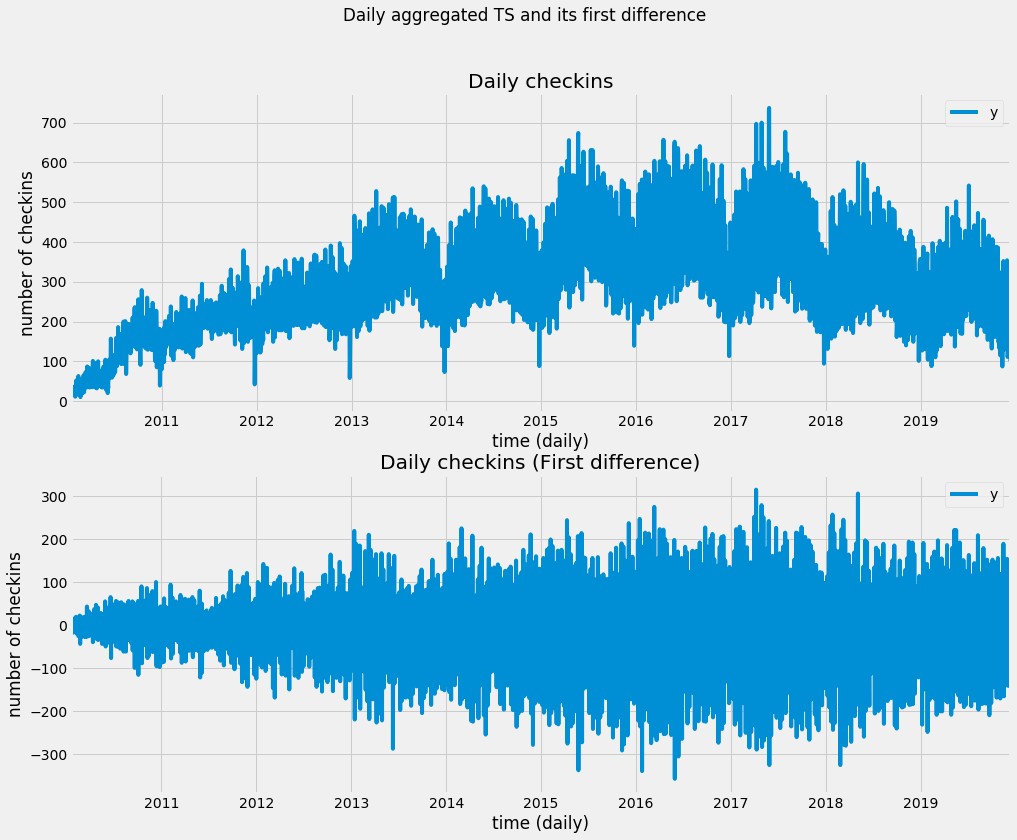

In [28]:
fig,ax = plt.subplots(2,1,figsize=(15,12))
daily_tor.plot(ax=ax[0])
daily_tor.diff().dropna().plot(ax=ax[1])
ax[0].set(title='Daily checkins', xlabel='time (daily)', ylabel='number of checkins')
ax[1].set(title='Daily checkins (First difference)', xlabel='time (daily)', ylabel='number of checkins')
fig.suptitle('Daily aggregated TS and its first difference')
plt.show()

- plotting ACF and PACF to identify auto-regression and moving average parameters

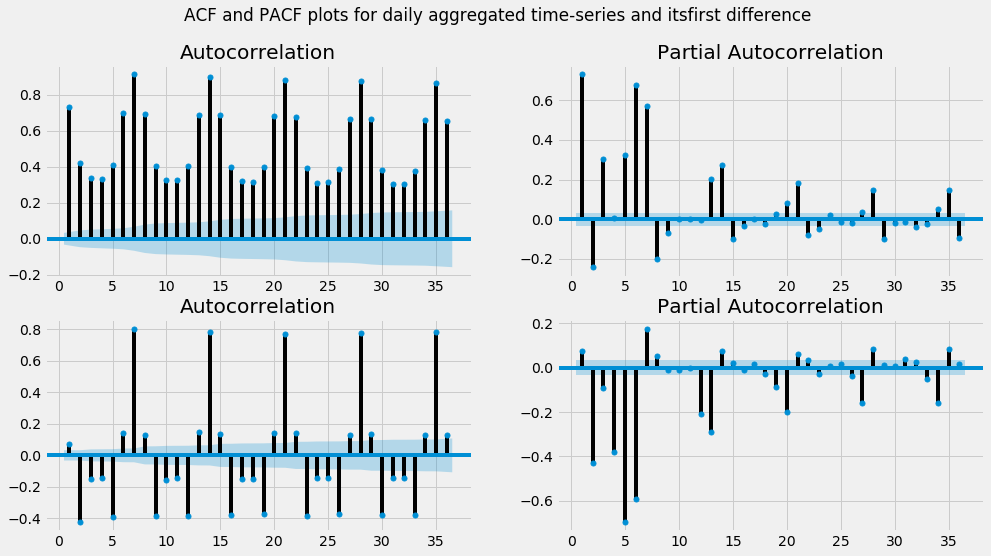

In [21]:
fig, ax = plt.subplots(2,2, figsize=(15,8))
plot_acf(daily_tor,ax=ax[0][0],zero=False)
plot_acf(daily_tor.diff().dropna(),ax=ax[1][0],zero=False)
plot_pacf(daily_tor,ax=ax[0][1],zero=False)
plot_pacf(daily_tor.diff().dropna(),ax=ax[1][1],zero=False)
fig.suptitle('ACF and PACF plots for daily aggregated time-series and itsfirst difference')
plt.show()

- train and test split of time series for estimating performance of different forecasting models 

In [96]:
def train_test_split(ts_df):
    test_split = '2019-01-01'
    train = ts_df.loc[ts_df.index < test_split].copy()
    test = ts_df.loc[(ts_df.index >= test_split)].copy()
    print(train.shape)
    print(test.shape)
    return (train,test)

d_train, d_test = train_test_split(daily_tor)

(3272, 1)
(347, 1)


### ARIMA

- finding parameters p and q for ARIMA model using 'AIC' and 'BIC'

In [97]:
order_aic_bic =[]
for p in range(8):
    for q in range(8):
        try:
            model = SARIMAX(d_train, order=(p,1,q))
            results = model.fit()
            order_aic_bic.append((p, q, results.aic, results.bic))
            print('ARIMA({},{}) - AIC:{}, BIC:{}'.format(p, q, results.aic, results.bic))
        except:
            continue
order_df = pd.DataFrame(order_aic_bic, columns=['p','q', 'aic', 'bic'])

ARIMA(0,0) - AIC:38603.88018707453, BIC:38609.97303810207
ARIMA(0,1) - AIC:38530.617932856665, BIC:38542.80363491174
ARIMA(0,2) - AIC:36947.28126539414, BIC:36965.55981847675
ARIMA(0,3) - AIC:36941.545210824705, BIC:36965.91661493486
ARIMA(0,4) - AIC:36432.59441703111, BIC:36463.0586721688
ARIMA(0,5) - AIC:37299.635397926, BIC:37336.19250409123
ARIMA(0,6) - AIC:36438.2668608612, BIC:36480.91681805397
ARIMA(0,7) - AIC:35855.56135502926, BIC:35904.304163249566
ARIMA(1,0) - AIC:38589.784519002846, BIC:38601.97022105792
ARIMA(1,1) - AIC:38352.603904521486, BIC:38370.8824576041
ARIMA(1,2) - AIC:36945.94541728626, BIC:36970.316821396416
ARIMA(1,3) - AIC:36660.07757064286, BIC:36690.54182578055
ARIMA(1,4) - AIC:36373.057902951594, BIC:36409.615009116824
ARIMA(1,5) - AIC:37281.259348514024, BIC:37323.909305706795
ARIMA(1,6) - AIC:36384.76274595866, BIC:36433.50555417896
ARIMA(1,7) - AIC:35829.1974446278, BIC:35884.03310387565
ARIMA(2,0) - AIC:37927.00984977346, BIC:37945.28840285607
ARIMA(2,1)

In [98]:
print(order_df.sort_values('aic').iloc[0,:])
print(order_df.sort_values('bic').iloc[0,:])

p          7.000000
q          7.000000
aic    32946.378332
bic    33037.771097
Name: 63, dtype: float64
p          7.000000
q          7.000000
aic    32946.378332
bic    33037.771097
Name: 63, dtype: float64


In [139]:
arima = SARIMAX(d_train, order=(7,1,7)).fit()
res = arima.resid
print(np.mean(np.abs(res)))

27.101700888405087


In [140]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3272
Model:               SARIMAX(7, 1, 7)   Log Likelihood              -16458.189
Date:                Thu, 07 May 2020   AIC                          32946.378
Time:                        19:27:49   BIC                          33037.771
Sample:                    01-16-2010   HQIC                         32979.108
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6581      0.024    -26.945      0.000      -0.706      -0.610
ar.L2         -0.6711      0.022    -30.974      0.000      -0.714      -0.629
ar.L3         -0.6649      0.023    -29.246      0.000      -0.709      -0.620
ar.L4         -0.6657      0.023    -29.174      0.000      -0.710      -0.621
ar.L5         -0.6709      0.022    -30.950      0.000      -0.713      -0.628
ar.L6         -0.6521      0.024    -27.376      0.000      -0.699      -0.605
ar.L7          0.3151      0.020     15.372      0.000       0.275       0.355
ma.L1          0.0446      0.021      2.108      0.035       0.003       0.086
ma.L2          0.0368      0.017      2.211      0.027       0.004       0.069
ma.L3          0.0516      0.017      3.039      0.002       0.018       0.085
ma.L4          0.0854      0.018      4.872      0.000       0.051       0.120
ma.L5          0.0500      0.017      2.921      0.003       0.016       0.084
ma.L6          0.0448      0.017      2.688      0.007       0.012       0.077
ma.L7         -0.7654      0.016    -47.316      0.000      -0.797      -0.734
sigma2      1507.0546     29.063     51.854      0.000    1450.092    1564.017
===================================================================================
Ljung-Box (Q):                      110.50   Jarque-Bera (JB):              1023.34
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.65   Skew:                             0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- residuals are correlated and not normal

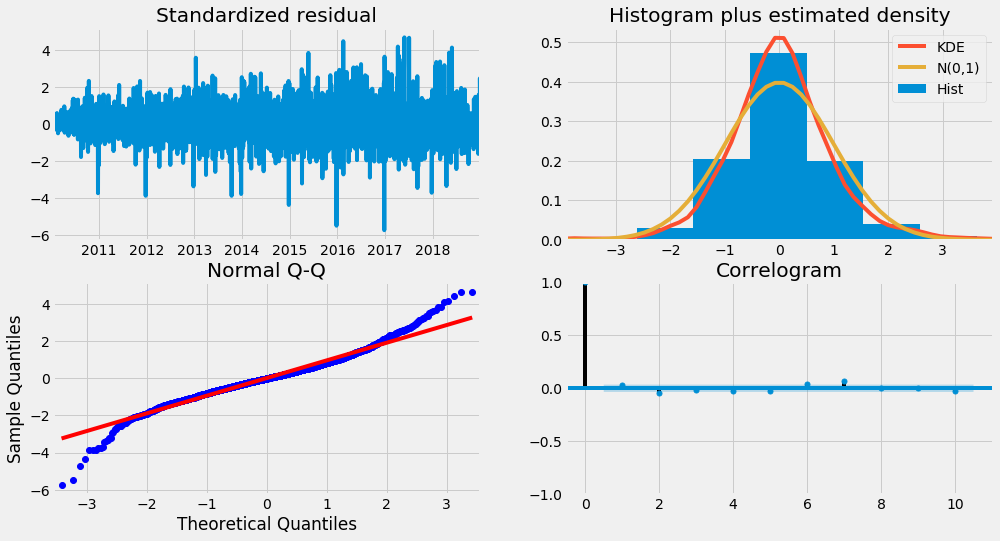

In [141]:
arima.plot_diagnostics()
plt.show()

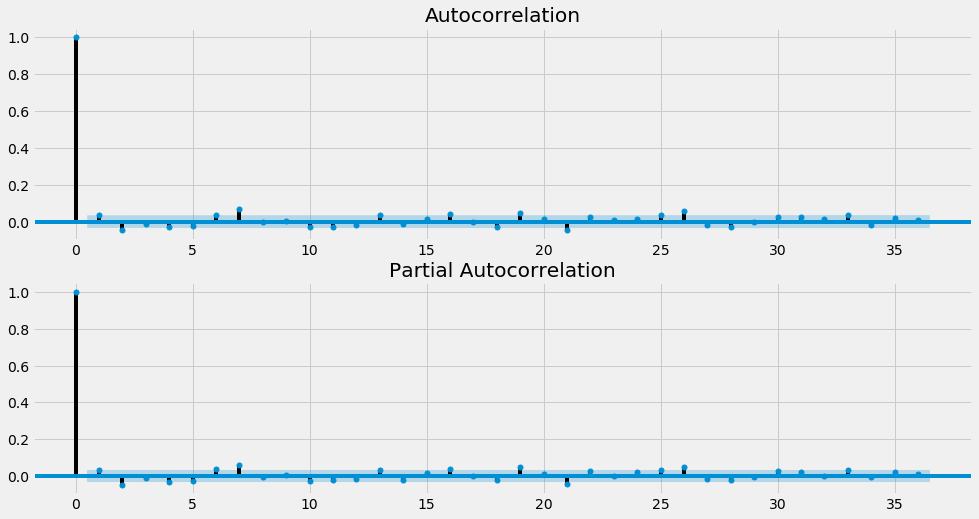

In [142]:
fig, ax = plt.subplots(2,1)
plot_acf(arima.resid,ax=ax[0])
plot_pacf(arima.resid,ax=ax[1])
plt.show()

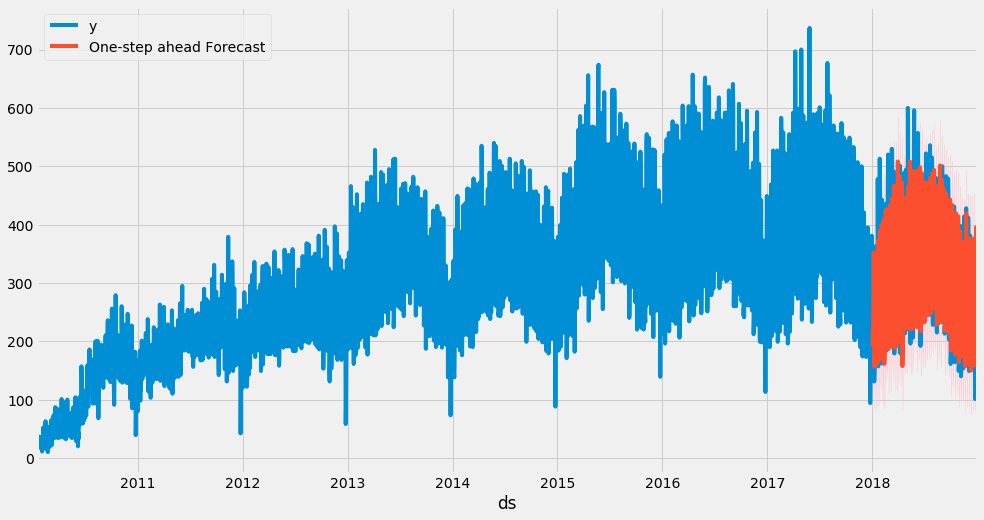

In [143]:
pred = arima.get_prediction(start=-364)
pred_ci = pred.conf_int()

fig, ax = plt.subplots()
d_train.plot(label='observed',ax=ax)
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast')
plt.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='pink', alpha=0.5)
plt.legend()
plt.show()

In [144]:
rmse = math.sqrt(mean_squared_error(d_train[-364:], pred.predicted_mean))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 38.42012369011367.


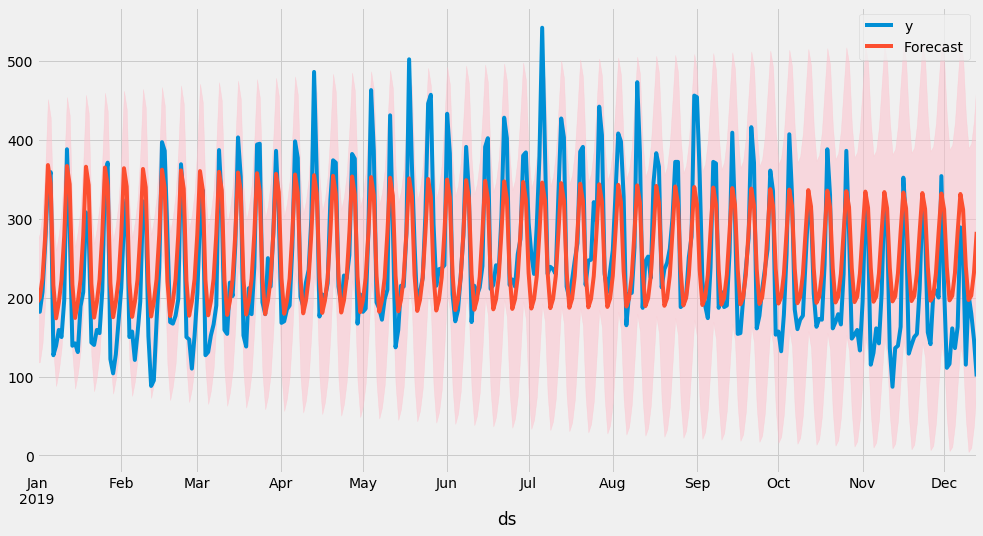

In [145]:
fcast = arima.get_forecast(steps=d_test.shape[0])
fcast_ci = fcast.conf_int()

fig, ax = plt.subplots()
d_test.plot(label='test',ax=ax)
fcast.predicted_mean.plot(ax=ax, label='Forecast')
plt.fill_between(fcast_ci.index,
                fcast_ci.iloc[:, 0],
                fcast_ci.iloc[:, 1], color='pink', alpha=0.5)
plt.legend()
plt.show()

In [146]:
rmse = math.sqrt(mean_squared_error(d_test, fcast.predicted_mean))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 55.84235357739692.


### SARIMA
- plotting ACF to find the period for seasonality

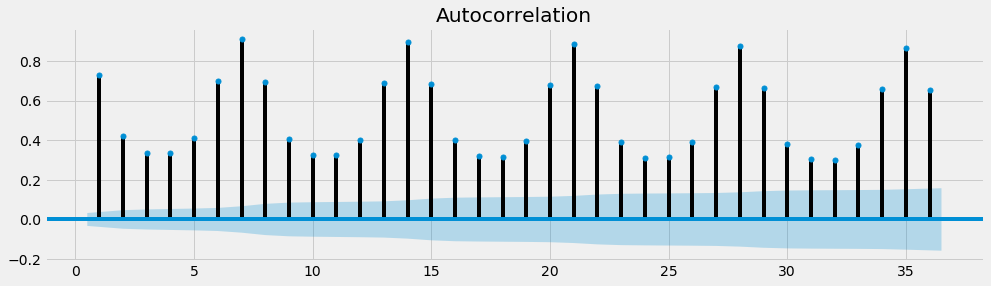

In [106]:
fig,ax = plt.subplots(figsize=(15,4))
plot_acf(daily_tor,ax=ax,zero=False)
plt.show()

- period = 7, 'weekly' seasonality
- seasonal decomposition of time series

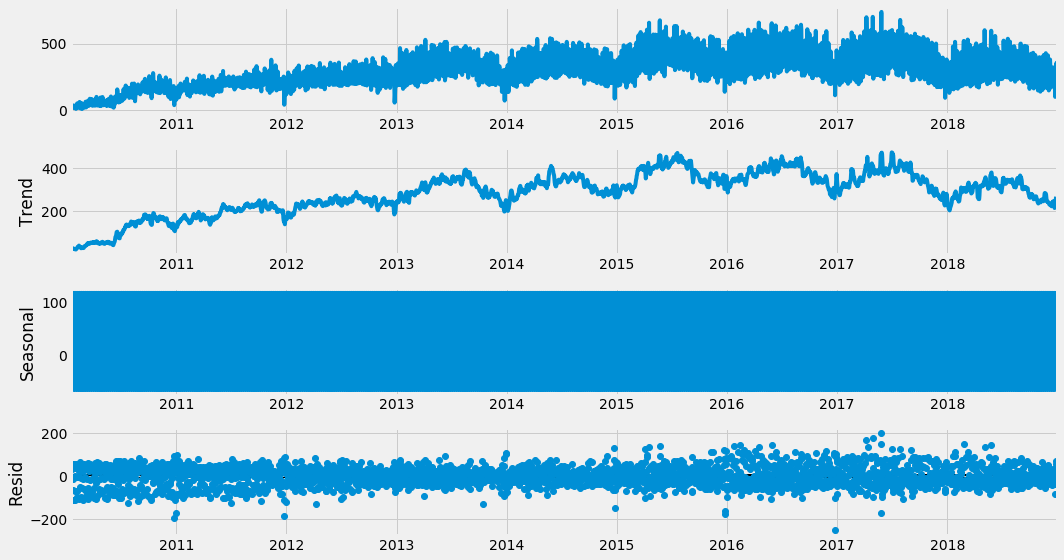

In [107]:
decomposition = sm.tsa.seasonal_decompose(d_train, model='additive',freq=7)
fig = decomposition.plot()
plt.show()

- since the seasonality is not clearly visible, drilling down on the data

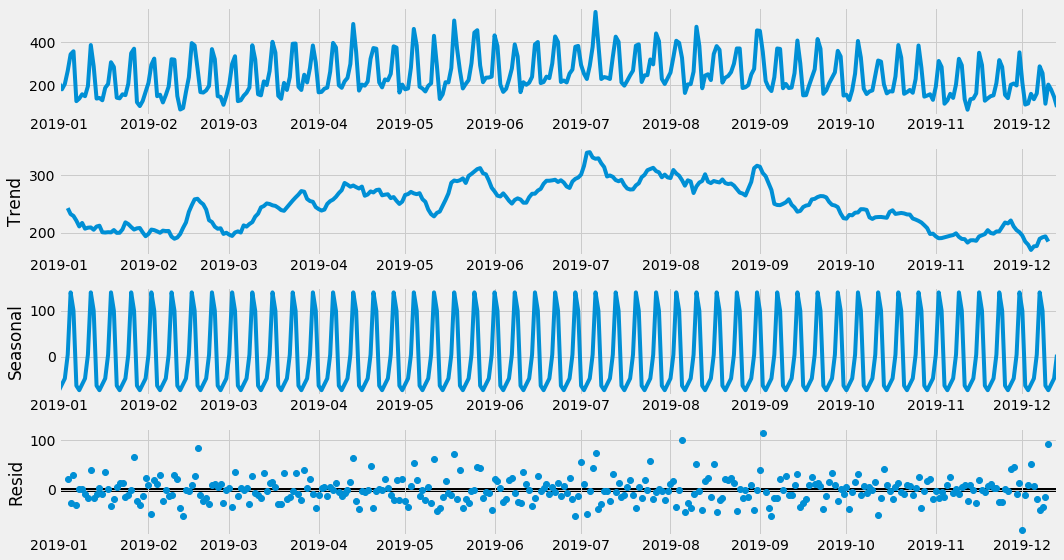

In [108]:
decomposition = sm.tsa.seasonal_decompose(d_test, model='additive',freq=7)
fig = decomposition.plot()
plt.show()

- detrending the data to remove seasonal effect

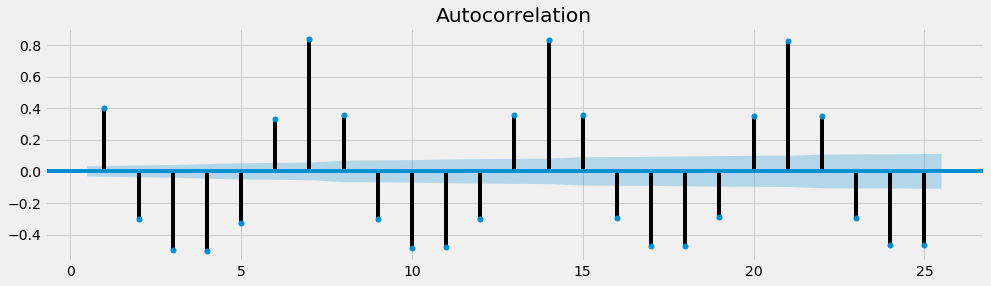

In [109]:
detrend = daily_tor - daily_tor.rolling(7).mean()
fig, ax = plt.subplots(figsize=(15,4))
plot_acf(detrend.dropna(), ax=ax, lags=25, zero=False)
plt.show()

- plotting time series, its first difference and its first seasonal difference 

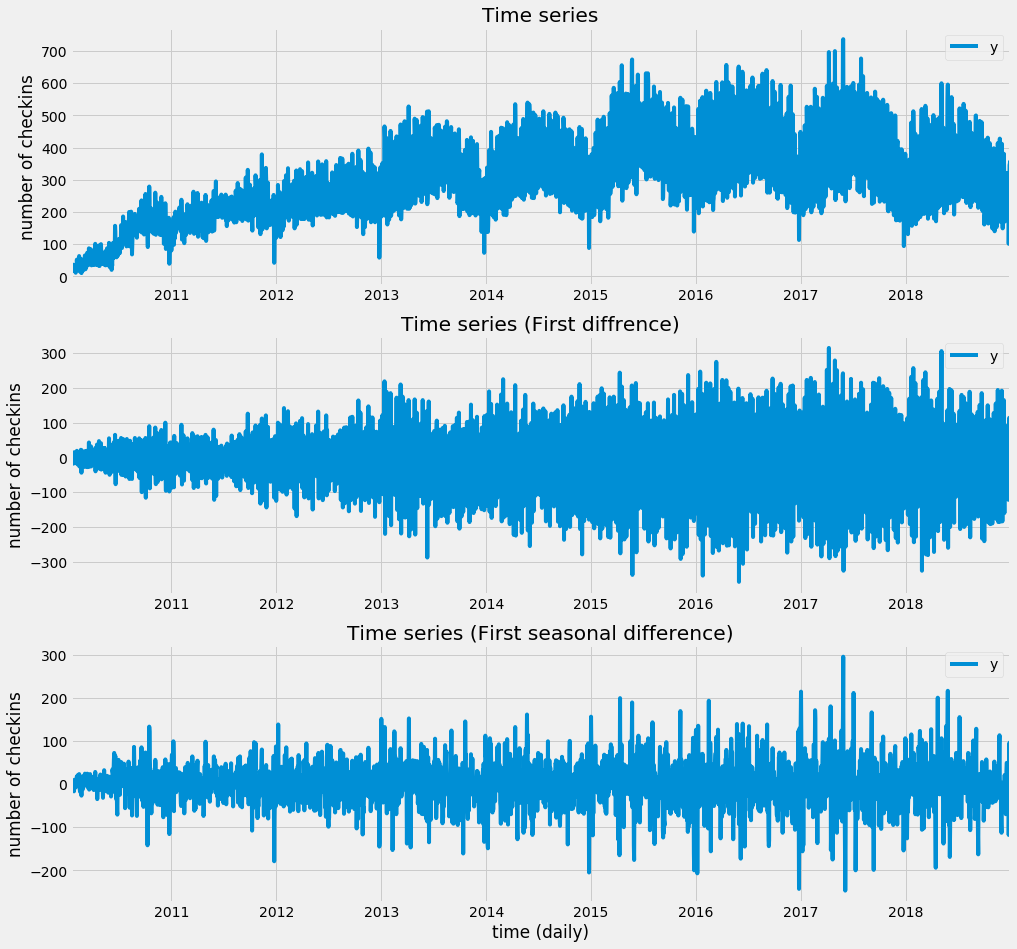

In [187]:
fig, ax = plt.subplots(3,1,figsize=(15,15))
d_train.plot(ax=ax[0])
d_train.diff().plot(ax=ax[1])
d_train.diff(7).plot(ax=ax[2])
ax[0].set(title='Time series', xlabel='', ylabel='number of checkins')
ax[1].set(title='Time series (First diffrence)', xlabel='', ylabel='number of checkins')
ax[2].set(title='Time series (First seasonal difference)', xlabel='time (daily)', ylabel='number of checkins')
plt.show()

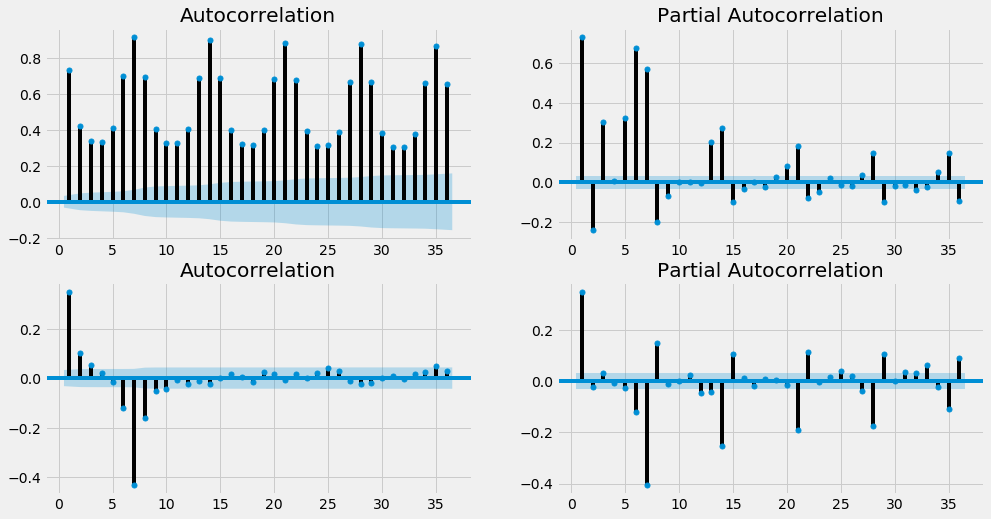

In [111]:
fig, ax = plt.subplots(2,2, figsize=(15,8))
plot_acf(daily_tor,ax=ax[0][0],zero=False)
plot_acf(daily_tor.diff(7).dropna(),ax=ax[1][0],zero=False)
plot_pacf(daily_tor,ax=ax[0][1],zero=False)
plot_pacf(daily_tor.diff(7).dropna(),ax=ax[1][1],zero=False)
plt.show()

In [112]:
p = range(0,3)
q = range(0,3)
d = range(1,2)
s = range(7,8)

order_aic_bic = []
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(p, d, q, s))

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            model = SARIMAX(d_train,
                            order=param,
                            seasonal_order=param_seasonal)
            results = model.fit()
            order_aic_bic.append((p, q, results.aic, results.bic))
            print('SARIMA{},{} - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
            
order_df = pd.DataFrame(order_aic_bic, columns=['param','s_param', 'aic', 'bic'])

SARIMA(0, 1, 0),(0, 1, 0, 7) - AIC:35515.19435402351
SARIMA(0, 1, 0),(0, 1, 1, 7) - AIC:33844.11875936677
SARIMA(0, 1, 0),(0, 1, 2, 7) - AIC:33808.44299715889
SARIMA(0, 1, 0),(1, 1, 0, 7) - AIC:34812.826563453506
SARIMA(0, 1, 0),(1, 1, 1, 7) - AIC:33807.51329321225
SARIMA(0, 1, 0),(1, 1, 2, 7) - AIC:33809.511625250045
SARIMA(0, 1, 0),(2, 1, 0, 7) - AIC:34553.47356930741
SARIMA(0, 1, 0),(2, 1, 1, 7) - AIC:33809.5104019109
SARIMA(0, 1, 0),(2, 1, 2, 7) - AIC:33810.896642464766
SARIMA(0, 1, 1),(0, 1, 0, 7) - AIC:34660.45752258255
SARIMA(0, 1, 1),(0, 1, 1, 7) - AIC:33081.23584222666
SARIMA(0, 1, 1),(0, 1, 2, 7) - AIC:33062.16871815664
SARIMA(0, 1, 1),(1, 1, 0, 7) - AIC:34028.53695909656
SARIMA(0, 1, 1),(1, 1, 1, 7) - AIC:33060.96251737595
SARIMA(0, 1, 1),(1, 1, 2, 7) - AIC:33061.943252863224
SARIMA(0, 1, 1),(2, 1, 0, 7) - AIC:33749.64068404697
SARIMA(0, 1, 1),(2, 1, 1, 7) - AIC:33061.45778840436
SARIMA(0, 1, 1),(2, 1, 2, 7) - AIC:33063.21987013795
SARIMA(0, 1, 2),(0, 1, 0, 7) - AIC:34259.88

In [113]:
print(order_df.sort_values('aic').iloc[0,:])
print(order_df.sort_values('bic').iloc[0,:])

param      (0, 1, 2)
s_param    (0, 1, 2)
aic          32712.3
bic          32748.9
Name: 67, dtype: object
param      (0, 1, 2)
s_param    (0, 1, 2)
aic          32718.1
bic          32748.5
Name: 22, dtype: object


In [114]:
sarima = SARIMAX(d_train,order=(0,1,2),seasonal_order=(0,1,2,7), \
                enforce_stationarity=False, enforce_invertibility=False).fit()
res = sarima.resid
print(np.mean(np.abs(res)))

26.34005382100936


In [115]:
sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 3272
Model:             SARIMAX(0, 1, 2)x(0, 1, 2, 7)   Log Likelihood              -16274.858
Date:                           Thu, 07 May 2020   AIC                          32559.716
Time:                                   19:21:18   BIC                          32590.144
Sample:                               01-16-2010   HQIC                         32570.617
                                    - 12-31-2018                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7423      0.018    -41.111      0.000      -0.778      -0.707
ma.L2         -0.3746      0.013    -27.909      0.000      -0.401      -0.348
ma.S.L7       -0.8388      0.015    -55.619      0.000      -0.868      -0.809
ma.S.L14      -0.0990      0.015     -6.523      0.000      -0.129      -0.069
sigma2      1114.7482     24.163     46.135      0.000    1067.391    1162.106
===================================================================================
Ljung-Box (Q):                       78.95   Jarque-Bera (JB):              1127.16
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.45   Skew:                             0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

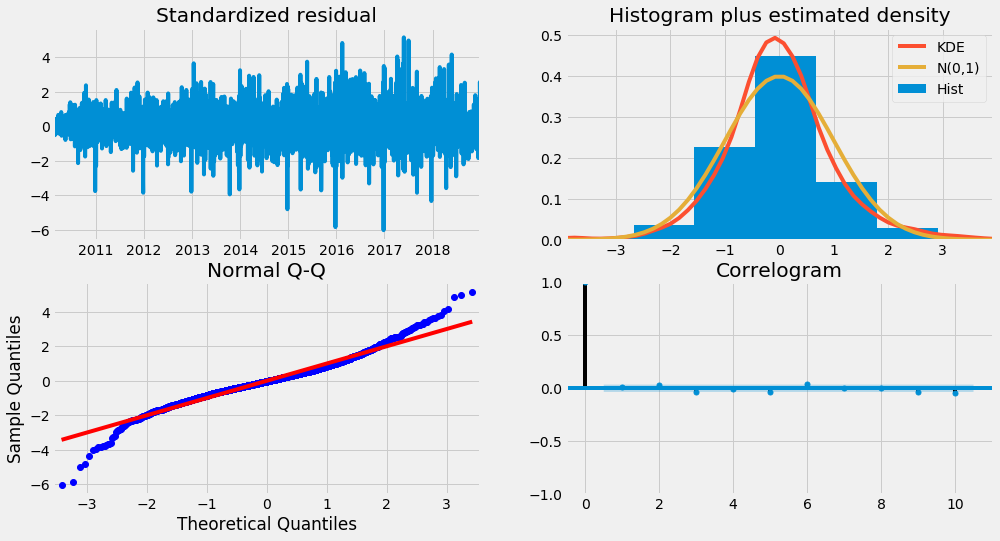

In [116]:
sarima.plot_diagnostics()
plt.show()

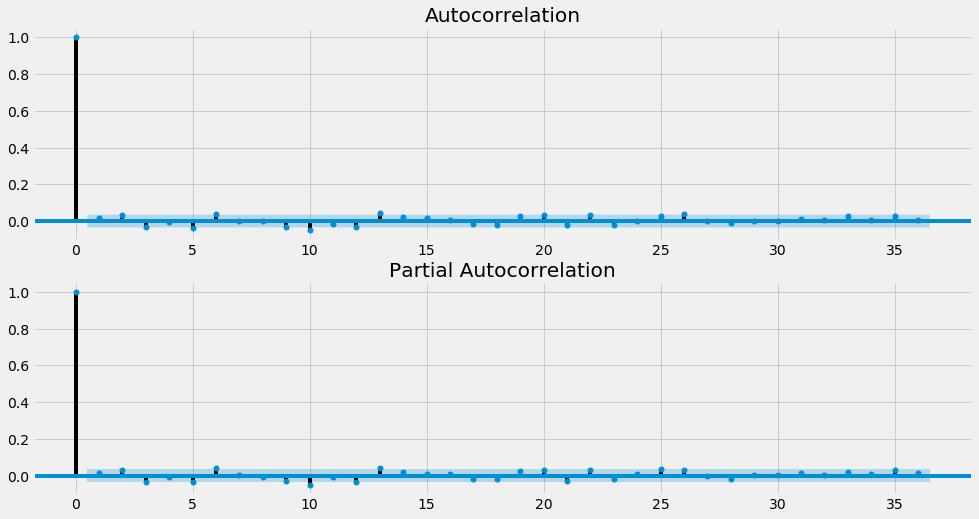

In [117]:
fig, ax = plt.subplots(2,1)
plot_acf(res,ax=ax[0])
plot_pacf(res,ax=ax[1])
plt.show()

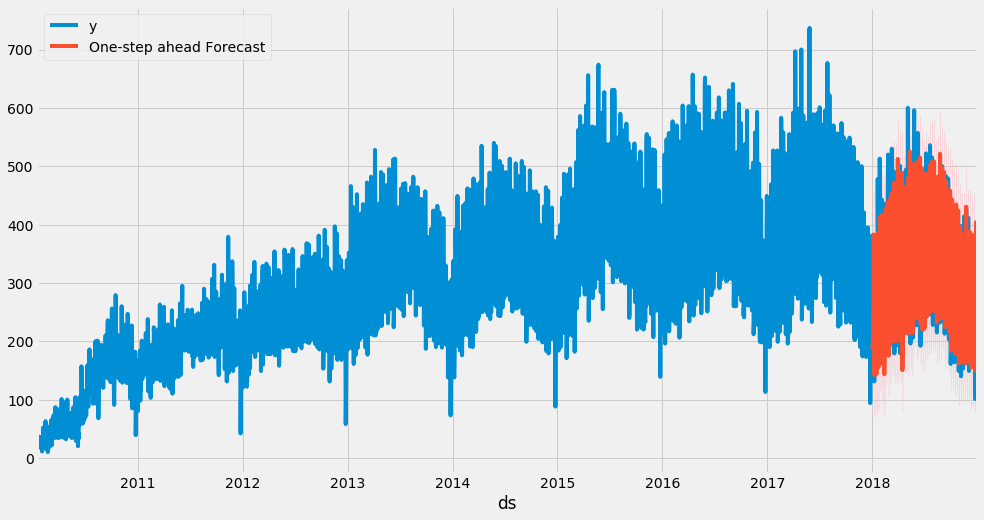

In [136]:
pred = sarima.get_prediction(start=-364)
pred_ci = pred.conf_int()

fig, ax = plt.subplots()
d_train.plot(label='observed',ax=ax)
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast')
plt.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='pink', alpha=0.5)
plt.legend()
plt.show()

In [137]:
rmse = math.sqrt(mean_squared_error(d_train[-364:], pred.predicted_mean))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 37.48335594947776.


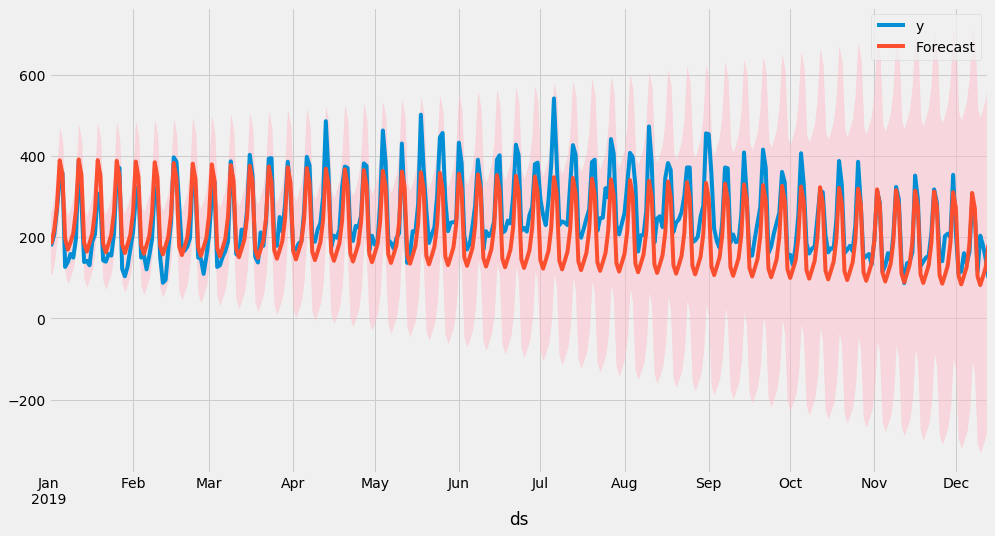

In [134]:
fcast = sarima.get_forecast(steps=d_test.shape[0])
fcast_ci = fcast.conf_int()

fig, ax = plt.subplots()
d_test.plot(label='test',ax=ax)
fcast.predicted_mean.plot(ax=ax, label='Forecast')
plt.fill_between(fcast_ci.index,
                fcast_ci.iloc[:, 0],
                fcast_ci.iloc[:, 1], color='pink', alpha=0.5)
plt.legend()
plt.show()

In [138]:
rmse = math.sqrt(mean_squared_error(d_test, fcast.predicted_mean))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 65.42432404012712.


### Prophet
- checking different seasonality levels

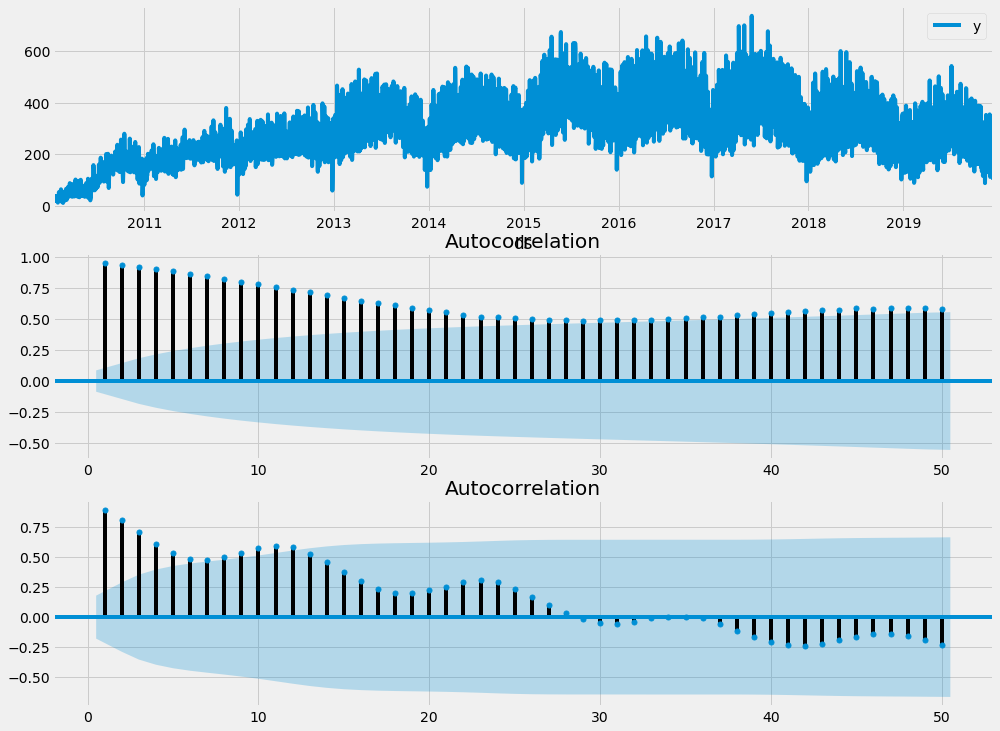

In [186]:
fig,ax = plt.subplots(3,1, figsize=(15,12))
daily_tor.plot(ax=ax[0]) 
daily_tor.loc[(daily_tor.index > '2018-01-01') and (daily_tor.index < '2018-01-01'), :] \
            .resample('W').sum().loc[daily].plot(ax=ax[1]) 
plot_acf(daily_tor.resample('M').sum(), lags=50,zero=False,ax=ax[2]) # to check for yearly seasonality
plt.show()

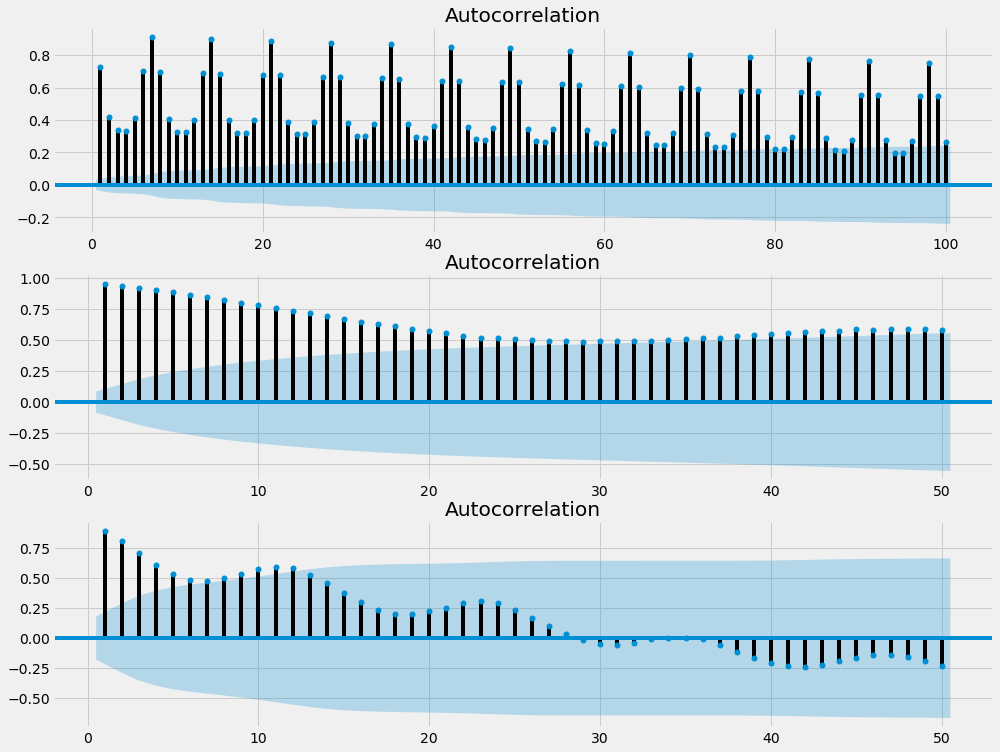

In [175]:
fig,ax = plt.subplots(3,1, figsize=(15,12))
plot_acf(daily_tor, lags=100,zero=False,ax=ax[0]) # to check for weekly seasonality 
plot_acf(daily_tor.resample('W').sum(), lags=50,zero=False,ax=ax[1]) # to check for monthly seasonality
plot_acf(daily_tor.resample('M').sum(), lags=50,zero=False,ax=ax[2]) # to check for yearly seasonality
plt.show()

- looks like the time series shows both weekly and yearly seasonality

In [147]:
from fbprophet import Prophet

In [242]:
prophet = Prophet(interval_width=0.95,
        yearly_seasonality=True,
        weekly_seasonality=True,
        daily_seasonality=False,
        ).fit(d_train.reset_index())

In [243]:
future_pd = prophet.make_future_dataframe(
  periods=d_test.shape[0], 
  freq='D', 
  include_history=True
  )

# predict over the dataset
forecast_pd = prophet.predict(future_pd)

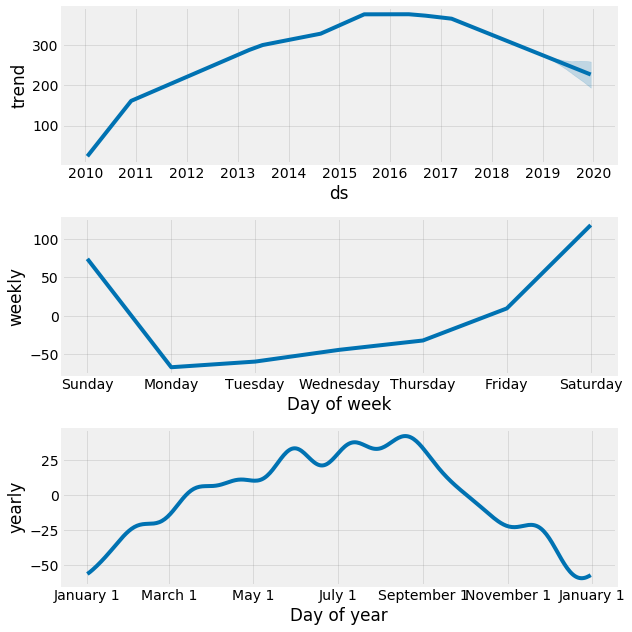

In [244]:
prophet.plot_components(forecast_pd)
plt.show()

(736856.9, 737496.9)

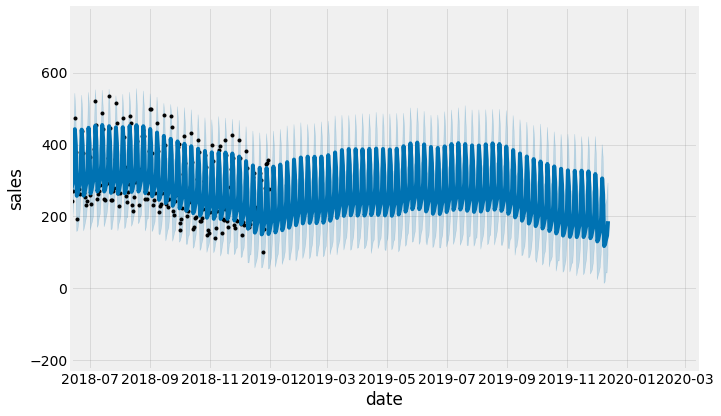

In [245]:
predict_fig = prophet.plot(forecast_pd, xlabel='date', ylabel='sales')

# adjust figure to display dates from last year + the 90 day forecast
xlim = predict_fig.axes[0].get_xlim()
new_xlim = ( xlim[1]-(730), xlim[1]-90.0)
predict_fig.axes[0].set_xlim(new_xlim)

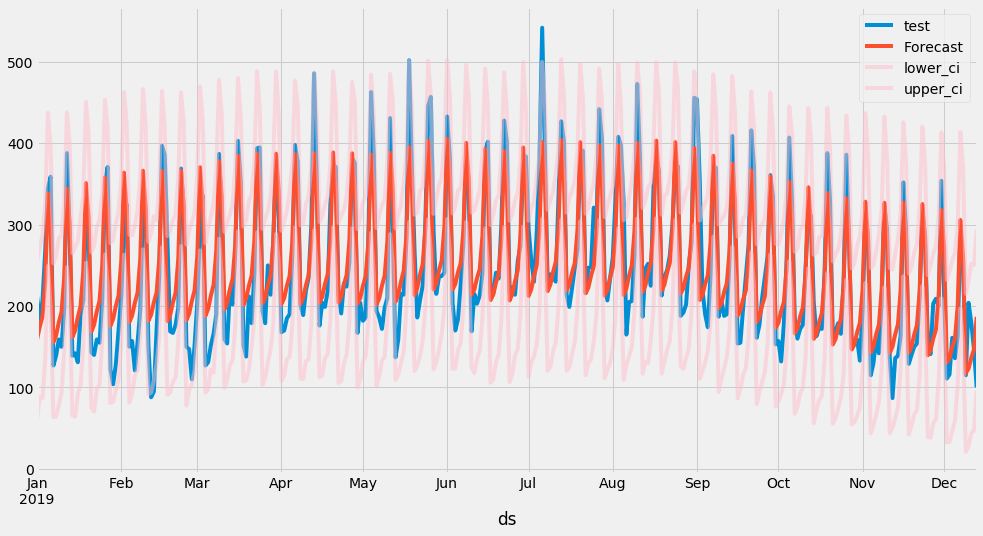

In [246]:
fcast = prophet.predict(d_test.reset_index())

fig, ax = plt.subplots()
d_test.reset_index().plot(x='ds',y='y',label='test',ax=ax)
fcast.plot(x='ds',y='yhat',ax=ax, label='Forecast')
fcast.plot(x='ds',y='yhat_lower',ax=ax, label='lower_ci',color='pink',alpha=0.5)
fcast.plot(x='ds',y='yhat_upper',ax=ax, label='upper_ci',color='pink',alpha=0.5)
plt.legend()
plt.show()

In [247]:
rmse = math.sqrt(mean_squared_error(d_test, fcast.yhat))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 39.56282185357504.


In [249]:
mape = np.mean(np.abs((np.array(d_test.y) - np.array(fcast.yhat)) / np.array(d_test.y))) * 100
print("The mean average percentage error is {}.".format(mape))

The mean average percentage error is 14.700938614256781.
